In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Softmax, Dense, Add, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from tensorflow.keras.applications import EfficientNetB6

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 实例化 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像像素值进行归一化
    rotation_range=20,  # 旋转范围
    width_shift_range=0.2,  # 水平平移范围
    height_shift_range=0.2,  # 垂直平移范围
    horizontal_flip=True,  # 水平翻转
    vertical_flip=True,  # 垂直翻转
    zoom_range=0.2,  # 缩放范围
    brightness_range=[0.8,1.2]  # 亮度范围
)

# 创建训练集生成器
train_generator = train_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/train',  # 训练集目录
    target_size=(224, 224),  # 图像尺寸
    batch_size=4,
    class_mode='categorical'  # 类别模式
)

# 同理，为验证集创建生成器
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

Found 23952 images belonging to 3 classes.
Found 2663 images belonging to 3 classes.


In [3]:
# 创建EfficientNetB6模型
def create_efficientnetb6(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # 使用EfficientNetB6的预训练模型，不包括顶部的分类层
    base_model = EfficientNetB6(include_top=False, input_tensor=inputs, weights='imagenet')

    # 添加新的顶层分类层
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='swish', kernel_regularizer=l2(1e-6))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='swish', kernel_regularizer=l2(1e-6))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='swish', kernel_regularizer=l2(1e-6))(x)  
    
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# 创建EfficientNetB6模型
model = create_efficientnetb6(input_shape=(224, 224, 3), num_classes=3)
model.compile(optimizer=Nadam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


165234480/165234480 [==============================] - 28s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLamb

                                )                                 'block1a_project_bn[0][0]']     
                                                                                                  
 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
          

                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 240)  960        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 240)  0          ['block2b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_s

 )                                                                                                
                                                                                                  
 block2d_se_squeeze (GlobalAver  (None, 240)         0           ['block2d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2d_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2d_se_squeeze[0][0]']     
                                                                                                  
 block2d_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2d_se_reshape[0][0]']     
                                                                                                  
 block2d_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2d_se_reduce[0][0]']      
          

 block2f_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2f_se_squeeze[0][0]']     
                                                                                                  
 block2f_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2f_se_reshape[0][0]']     
                                                                                                  
 block2f_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2f_se_reduce[0][0]']      
                                                                                                  
 block2f_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2f_activation[0][0]',     
                                                                  'block2f_se_expand[0][0]']      
                                                                                                  
 block2f_project_conv (Conv2D)  (None, 56, 56, 40)   9600        ['block2f_se_excite[0][0]']      
          

                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 72)   31104       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 72)  288         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 72)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 72)   0           ['block3b_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block3d_drop (Dropout)         (None, 28, 28, 72)   0           ['block3d_project_bn[0][0]']     
                                                                                                  
 block3d_add (Add)              (None, 28, 28, 72)   0           ['block3d_drop[0][0]',           
                                                                  'block3c_add[0][0]']            
                                                                                                  
 block3e_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3d_add[0][0]']            
                                                                                                  
 block3e_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block3e_expand_conv[0][0]']    
 ization) 

                                                                  'block3e_add[0][0]']            
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3f_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 28, 28, 432)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_d

 block4c_expand_activation (Act  (None, 14, 14, 864)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 864)  7776       ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 864)  3456       ['block4c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 14, 14, 864)  0          ['block4c_bn[0][0]']             
 )        

                                                                                                  
 block4e_bn (BatchNormalization  (None, 14, 14, 864)  3456       ['block4e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4e_activation (Activation  (None, 14, 14, 864)  0          ['block4e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 864)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_s

 )                                                                                                
                                                                                                  
 block4g_se_squeeze (GlobalAver  (None, 864)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block4g_se_reduce[0][0]']      
          

 block5a_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 14, 14, 864)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 14, 14, 200)  172800      ['block5a_se_excite[0][0]']      
          

                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 200)  240000      ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 200)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 14, 14, 200)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
          

 block5e_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_drop (Dropout)         (None, 14, 14, 200)  0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 14, 14, 200)  0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
                                                                                                  
 block5f_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5e_add[0][0]']            
                                )                                                                 
          

 block5g_drop (Dropout)         (None, 14, 14, 200)  0           ['block5g_project_bn[0][0]']     
                                                                                                  
 block5g_add (Add)              (None, 14, 14, 200)  0           ['block5g_drop[0][0]',           
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5g_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 14, 14, 1200  4800       ['block5h_expand_conv[0][0]']    
 ization)                       )                                                                 
          

 block6b_expand_conv (Conv2D)   (None, 7, 7, 2064)   710016      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 2064)  8256        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 2064)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
          

 block6d_expand_activation (Act  (None, 7, 7, 2064)  0           ['block6d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 2064)  0           ['block6d_bn[0][0]']             
 )        

                                                                                                  
 block6f_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6f_activation (Activation  (None, 7, 7, 2064)  0           ['block6f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 2064)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_s

 )                                                                                                
                                                                                                  
 block6h_se_squeeze (GlobalAver  (None, 2064)        0           ['block6h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6h_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6h_se_squeeze[0][0]']     
                                                                                                  
 block6h_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6h_se_reshape[0][0]']     
                                                                                                  
 block6h_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6h_se_reduce[0][0]']      
          

 block6j_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6j_se_squeeze[0][0]']     
                                                                                                  
 block6j_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6j_se_reshape[0][0]']     
                                                                                                  
 block6j_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6j_se_reduce[0][0]']      
                                                                                                  
 block6j_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block6j_activation[0][0]',     
                                                                  'block6j_se_expand[0][0]']      
                                                                                                  
 block6j_project_conv (Conv2D)  (None, 7, 7, 344)    710016      ['block6j_se_excite[0][0]']      
          

                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 7, 7, 576)    1188864     ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 7, 7, 576)   2304        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 7, 7, 3456)   1990656     ['block7a_project_bn[0][0]']     
          

                                                                                                  
 block7c_add (Add)              (None, 7, 7, 576)    0           ['block7c_drop[0][0]',           
                                                                  'block7b_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 2304)   1327104     ['block7c_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 2304)   9216        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 7, 7, 2304)   0           ['top_bn[0][0]']                 
                                                                                                  
 global_av

In [4]:
# 创建ModelCheckpoint回调，保存验证准确率最高的模型
checkpoint = ModelCheckpoint(r'D:\tf29\Go_competition\AIcupTutorial-main\models\checkpoint\checkpoint_best_model_playstyle(efficientnetb6).h5', save_best_only=True, monitor='val_accuracy')

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8),
        checkpoint
    ]
)

Epoch 1/100
5988/5988 [==============================] - 1782s 290ms/step - loss: 1.0967 - accuracy: 0.3723 - val_loss: 1.0789 - val_accuracy: 0.3984 - lr: 2.0000e-04
Epoch 2/100
5988/5988 [==============================] - 1802s 301ms/step - loss: 1.0660 - accuracy: 0.4233 - val_loss: 0.9719 - val_accuracy: 0.5272 - lr: 2.0000e-04
Epoch 3/100
5988/5988 [==============================] - 1863s 311ms/step - loss: 0.9442 - accuracy: 0.5675 - val_loss: 0.8820 - val_accuracy: 0.5914 - lr: 2.0000e-04
Epoch 4/100
5988/5988 [==============================] - 1817s 303ms/step - loss: 0.8707 - accuracy: 0.6231 - val_loss: 0.8288 - val_accuracy: 0.6515 - lr: 2.0000e-04
Epoch 5/100
5988/5988 [==============================] - 1823s 304ms/step - loss: 0.8348 - accuracy: 0.6437 - val_loss: 0.7797 - val_accuracy: 0.6744 - lr: 2.0000e-04
Epoch 6/100
5988/5988 [==============================] - 1833s 306ms/step - loss: 0.8111 - accuracy: 0.6554 - val_loss: 0.8818 - val_accuracy: 0.5862 - lr: 2.0000e-0

KeyboardInterrupt: 

In [ ]:
model.save(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.688(image_v3.3,efficientnetb6).h5')

# 

# 以下內容為訓練中斷,需要重新讀取權重,繼續訓練的重複內容,無需進行執行

# 

In [1]:
'''
from tensorflow.keras.models import load_model
# 載入模型
model = load_model(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.688(image_v3.3,efficientnetb6).h5')
# 顯示模型架構
model.summary()
'''

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 240)  0          ['block2b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2b_se_squeeze[0][0]']     
                                                                                                  
 block2b_s

 block2d_se_squeeze (GlobalAver  (None, 240)         0           ['block2d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2d_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2d_se_squeeze[0][0]']     
                                                                                                  
 block2d_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2d_se_reshape[0][0]']     
                                                                                                  
 block2d_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2d_se_reduce[0][0]']      
                                                                                                  
 block2d_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2d_activation[0][0]',     
          

 block2f_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2f_se_reshape[0][0]']     
                                                                                                  
 block2f_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2f_se_reduce[0][0]']      
                                                                                                  
 block2f_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2f_activation[0][0]',     
                                                                  'block2f_se_expand[0][0]']      
                                                                                                  
 block2f_project_conv (Conv2D)  (None, 56, 56, 40)   9600        ['block2f_se_excite[0][0]']      
                                                                                                  
 block2f_project_bn (BatchNorma  (None, 56, 56, 40)  160         ['block2f_project_conv[0][0]']   
 lization)

 block3b_project_conv (Conv2D)  (None, 28, 28, 72)   31104       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 72)  288         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 72)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 72)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_e

 block3d_drop (Dropout)         (None, 28, 28, 72)   0           ['block3d_project_bn[0][0]']     
                                                                                                  
 block3d_add (Add)              (None, 28, 28, 72)   0           ['block3d_drop[0][0]',           
                                                                  'block3c_add[0][0]']            
                                                                                                  
 block3e_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3d_add[0][0]']            
                                                                                                  
 block3e_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block3e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3e_e

 block4a_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3f_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 28, 28, 432)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv_pad (ZeroPaddin  (None, 29, 29, 432)  0          ['block4a_expand_activation[0][0]
 g2D)                                                            ']                               
          

                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 864)  7776       ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 864)  3456       ['block4c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 14, 14, 864)  0          ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_s

 )                                                                                                
                                                                                                  
 block4e_activation (Activation  (None, 14, 14, 864)  0          ['block4e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 864)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_s

 block4g_se_squeeze (GlobalAver  (None, 864)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block4g_se_reduce[0][0]']      
                                                                                                  
 block4g_se_excite (Multiply)   (None, 14, 14, 864)  0           ['block4g_activation[0][0]',     
          

 block5a_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 14, 14, 864)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 14, 14, 200)  172800      ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5a_project_conv[0][0]']   
 lization)

                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 200)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 14, 14, 200)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5c_add[0][0]']            
          

                                                                                                  
 block5e_drop (Dropout)         (None, 14, 14, 200)  0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 14, 14, 200)  0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
                                                                                                  
 block5f_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5e_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5f_expand_bn (BatchNormal  (None, 14, 14, 1200  4800       ['block5f_expand_conv[0][0]']    
 ization) 

 block5g_add (Add)              (None, 14, 14, 200)  0           ['block5g_drop[0][0]',           
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5g_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 14, 14, 1200  4800       ['block5h_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5h_expand_activation (Act  (None, 14, 14, 1200  0          ['block5h_expand_bn[0][0]']      
 ivation) 

 block6b_expand_bn (BatchNormal  (None, 7, 7, 2064)  8256        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 2064)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6b_dwconv[0][0]']         
 )        

                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 2064)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_s

 )                                                                                                
                                                                                                  
 block6f_activation (Activation  (None, 7, 7, 2064)  0           ['block6f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 2064)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_s

 block6h_se_squeeze (GlobalAver  (None, 2064)        0           ['block6h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6h_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6h_se_squeeze[0][0]']     
                                                                                                  
 block6h_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6h_se_reshape[0][0]']     
                                                                                                  
 block6h_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6h_se_reduce[0][0]']      
                                                                                                  
 block6h_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block6h_activation[0][0]',     
          

 block6j_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6j_se_reshape[0][0]']     
                                                                                                  
 block6j_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6j_se_reduce[0][0]']      
                                                                                                  
 block6j_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block6j_activation[0][0]',     
                                                                  'block6j_se_expand[0][0]']      
                                                                                                  
 block6j_project_conv (Conv2D)  (None, 7, 7, 344)    710016      ['block6j_se_excite[0][0]']      
                                                                                                  
 block6j_project_bn (BatchNorma  (None, 7, 7, 344)   1376        ['block6j_project_conv[0][0]']   
 lization)

                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 7, 7, 576)    1188864     ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 7, 7, 576)   2304        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 7, 7, 3456)   1990656     ['block7a_project_bn[0][0]']     
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 7, 7, 3456)  13824       ['block7b_expand_conv[0][0]']    
 ization) 

                                                                  'block7b_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 2304)   1327104     ['block7c_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 2304)   9216        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 7, 7, 2304)   0           ['top_bn[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2304)        0           ['top_activation[0][0]']         
 alAveragePooling2D)                                                                              
          

In [2]:
'''
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Softmax, Dense, Add, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 实例化 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像像素值进行归一化
    rotation_range=20,  # 旋转范围
    width_shift_range=0.2,  # 水平平移范围
    height_shift_range=0.2,  # 垂直平移范围
    horizontal_flip=True,  # 水平翻转
    vertical_flip=True,  # 垂直翻转
    zoom_range=0.2,  # 缩放范围
    brightness_range=[0.8,1.2]  # 亮度范围
)

# 创建训练集生成器
train_generator = train_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/train',  # 训练集目录
    target_size=(224, 224),  # 图像尺寸
    batch_size=4,
    class_mode='categorical'  # 类别模式
)

# 同理，为验证集创建生成器
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)
'''

Found 23952 images belonging to 3 classes.
Found 2663 images belonging to 3 classes.


In [3]:
'''
# 创建ModelCheckpoint回调，保存验证准确率最高的模型
checkpoint = ModelCheckpoint(r'D:\tf29\Go_competition\AIcupTutorial-main\models\checkpoint\checkpoint_best_model_playstyle(efficientnetb0).h5', save_best_only=True, monitor='val_accuracy')

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8),
        checkpoint
    ]
)
'''

Epoch 1/100
5988/5988 [==============================] - 1834s 301ms/step - loss: 0.7764 - accuracy: 0.6765 - val_loss: 1.1123 - val_accuracy: 0.3808 - lr: 2.0000e-04
Epoch 2/100
5988/5988 [==============================] - 1784s 298ms/step - loss: 0.7659 - accuracy: 0.6835 - val_loss: 0.7889 - val_accuracy: 0.6703 - lr: 2.0000e-04
Epoch 3/100
   8/5988 [..............................] - ETA: 30:42 - loss: 0.9185 - accuracy: 0.7188

KeyboardInterrupt: 

In [4]:
#model.save(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.670(image_v3.3,efficientnetb6).h5')

In [1]:
'''
from tensorflow.keras.models import load_model
# 載入模型
model = load_model(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.670(image_v3.3,efficientnetb6).h5')
# 顯示模型架構
model.summary()
'''

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 240)  0          ['block2b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2b_se_squeeze[0][0]']     
                                                                                                  
 block2b_s

 block2d_se_squeeze (GlobalAver  (None, 240)         0           ['block2d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2d_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2d_se_squeeze[0][0]']     
                                                                                                  
 block2d_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2d_se_reshape[0][0]']     
                                                                                                  
 block2d_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2d_se_reduce[0][0]']      
                                                                                                  
 block2d_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2d_activation[0][0]',     
          

 block2f_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2f_se_reshape[0][0]']     
                                                                                                  
 block2f_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2f_se_reduce[0][0]']      
                                                                                                  
 block2f_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2f_activation[0][0]',     
                                                                  'block2f_se_expand[0][0]']      
                                                                                                  
 block2f_project_conv (Conv2D)  (None, 56, 56, 40)   9600        ['block2f_se_excite[0][0]']      
                                                                                                  
 block2f_project_bn (BatchNorma  (None, 56, 56, 40)  160         ['block2f_project_conv[0][0]']   
 lization)

 block3b_project_conv (Conv2D)  (None, 28, 28, 72)   31104       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 72)  288         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 72)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 72)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_e

 block3d_drop (Dropout)         (None, 28, 28, 72)   0           ['block3d_project_bn[0][0]']     
                                                                                                  
 block3d_add (Add)              (None, 28, 28, 72)   0           ['block3d_drop[0][0]',           
                                                                  'block3c_add[0][0]']            
                                                                                                  
 block3e_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3d_add[0][0]']            
                                                                                                  
 block3e_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block3e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3e_e

 block4a_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3f_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 28, 28, 432)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv_pad (ZeroPaddin  (None, 29, 29, 432)  0          ['block4a_expand_activation[0][0]
 g2D)                                                            ']                               
          

                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 864)  7776       ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 864)  3456       ['block4c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 14, 14, 864)  0          ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_s

 )                                                                                                
                                                                                                  
 block4e_activation (Activation  (None, 14, 14, 864)  0          ['block4e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 864)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_s

 block4g_se_squeeze (GlobalAver  (None, 864)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block4g_se_reduce[0][0]']      
                                                                                                  
 block4g_se_excite (Multiply)   (None, 14, 14, 864)  0           ['block4g_activation[0][0]',     
          

 block5a_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 14, 14, 864)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 14, 14, 200)  172800      ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5a_project_conv[0][0]']   
 lization)

                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 200)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 14, 14, 200)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5c_add[0][0]']            
          

                                                                                                  
 block5e_drop (Dropout)         (None, 14, 14, 200)  0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 14, 14, 200)  0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
                                                                                                  
 block5f_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5e_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5f_expand_bn (BatchNormal  (None, 14, 14, 1200  4800       ['block5f_expand_conv[0][0]']    
 ization) 

 block5g_add (Add)              (None, 14, 14, 200)  0           ['block5g_drop[0][0]',           
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5g_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 14, 14, 1200  4800       ['block5h_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5h_expand_activation (Act  (None, 14, 14, 1200  0          ['block5h_expand_bn[0][0]']      
 ivation) 

 block6b_expand_bn (BatchNormal  (None, 7, 7, 2064)  8256        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 2064)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6b_dwconv[0][0]']         
 )        

                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 2064)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_s

 )                                                                                                
                                                                                                  
 block6f_activation (Activation  (None, 7, 7, 2064)  0           ['block6f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 2064)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_s

 block6h_se_squeeze (GlobalAver  (None, 2064)        0           ['block6h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6h_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6h_se_squeeze[0][0]']     
                                                                                                  
 block6h_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6h_se_reshape[0][0]']     
                                                                                                  
 block6h_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6h_se_reduce[0][0]']      
                                                                                                  
 block6h_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block6h_activation[0][0]',     
          

 block6j_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6j_se_reshape[0][0]']     
                                                                                                  
 block6j_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6j_se_reduce[0][0]']      
                                                                                                  
 block6j_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block6j_activation[0][0]',     
                                                                  'block6j_se_expand[0][0]']      
                                                                                                  
 block6j_project_conv (Conv2D)  (None, 7, 7, 344)    710016      ['block6j_se_excite[0][0]']      
                                                                                                  
 block6j_project_bn (BatchNorma  (None, 7, 7, 344)   1376        ['block6j_project_conv[0][0]']   
 lization)

                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 7, 7, 576)    1188864     ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 7, 7, 576)   2304        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 7, 7, 3456)   1990656     ['block7a_project_bn[0][0]']     
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 7, 7, 3456)  13824       ['block7b_expand_conv[0][0]']    
 ization) 

                                                                  'block7b_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 2304)   1327104     ['block7c_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 2304)   9216        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 7, 7, 2304)   0           ['top_bn[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2304)        0           ['top_activation[0][0]']         
 alAveragePooling2D)                                                                              
          

In [2]:
'''
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Softmax, Dense, Add, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 实例化 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像像素值进行归一化
    rotation_range=20,  # 旋转范围
    width_shift_range=0.2,  # 水平平移范围
    height_shift_range=0.2,  # 垂直平移范围
    horizontal_flip=True,  # 水平翻转
    vertical_flip=True,  # 垂直翻转
    zoom_range=0.2,  # 缩放范围
    brightness_range=[0.8,1.2]  # 亮度范围
)

# 创建训练集生成器
train_generator = train_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/train',  # 训练集目录
    target_size=(224, 224),  # 图像尺寸
    batch_size=4,
    class_mode='categorical'  # 类别模式
)

# 同理，为验证集创建生成器
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)
'''

Found 23952 images belonging to 3 classes.
Found 2663 images belonging to 3 classes.


In [3]:
'''
# 创建ModelCheckpoint回调，保存验证准确率最高的模型
checkpoint = ModelCheckpoint(r'D:\tf29\Go_competition\AIcupTutorial-main\models\checkpoint\checkpoint_best_model_playstyle(efficientnetb6).h5', save_best_only=True, monitor='val_accuracy')

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8),
        checkpoint
    ]
)
'''

Epoch 1/100
5988/5988 [==============================] - 1775s 291ms/step - loss: 0.7665 - accuracy: 0.6804 - val_loss: 1.1297 - val_accuracy: 0.4300 - lr: 2.0000e-04
Epoch 2/100
5988/5988 [==============================] - 1791s 299ms/step - loss: 0.7550 - accuracy: 0.6884 - val_loss: 1.0179 - val_accuracy: 0.4916 - lr: 2.0000e-04
Epoch 3/100
5988/5988 [==============================] - 1790s 299ms/step - loss: 0.7499 - accuracy: 0.6924 - val_loss: 0.8094 - val_accuracy: 0.6406 - lr: 2.0000e-04
Epoch 4/100
5988/5988 [==============================] - 1757s 293ms/step - loss: 0.7440 - accuracy: 0.6939 - val_loss: 1.1589 - val_accuracy: 0.4003 - lr: 2.0000e-04
Epoch 5/100
5988/5988 [==============================] - 1796s 300ms/step - loss: 0.7393 - accuracy: 0.6943 - val_loss: 0.7377 - val_accuracy: 0.6981 - lr: 2.0000e-04
Epoch 6/100
5988/5988 [==============================] - 1790s 299ms/step - loss: 0.7352 - accuracy: 0.6973 - val_loss: 0.7940 - val_accuracy: 0.6725 - lr: 2.0000e-0

KeyboardInterrupt: 

In [ ]:
#model.save(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.701(image_v3.3,efficientnetb6).h5')

In [1]:
'''
from tensorflow.keras.models import load_model
# 載入模型
model = load_model(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.670(image_v3.3,efficientnetb6).h5')
# 顯示模型架構
model.summary()
'''

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 240)  0          ['block2b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2b_se_squeeze[0][0]']     
                                                                                                  
 block2b_s

 block2d_se_squeeze (GlobalAver  (None, 240)         0           ['block2d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2d_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2d_se_squeeze[0][0]']     
                                                                                                  
 block2d_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2d_se_reshape[0][0]']     
                                                                                                  
 block2d_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2d_se_reduce[0][0]']      
                                                                                                  
 block2d_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2d_activation[0][0]',     
          

 block2f_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2f_se_reshape[0][0]']     
                                                                                                  
 block2f_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2f_se_reduce[0][0]']      
                                                                                                  
 block2f_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2f_activation[0][0]',     
                                                                  'block2f_se_expand[0][0]']      
                                                                                                  
 block2f_project_conv (Conv2D)  (None, 56, 56, 40)   9600        ['block2f_se_excite[0][0]']      
                                                                                                  
 block2f_project_bn (BatchNorma  (None, 56, 56, 40)  160         ['block2f_project_conv[0][0]']   
 lization)

 block3b_project_conv (Conv2D)  (None, 28, 28, 72)   31104       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 72)  288         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 72)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 72)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_e

 block3d_drop (Dropout)         (None, 28, 28, 72)   0           ['block3d_project_bn[0][0]']     
                                                                                                  
 block3d_add (Add)              (None, 28, 28, 72)   0           ['block3d_drop[0][0]',           
                                                                  'block3c_add[0][0]']            
                                                                                                  
 block3e_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3d_add[0][0]']            
                                                                                                  
 block3e_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block3e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3e_e

 block4a_expand_conv (Conv2D)   (None, 28, 28, 432)  31104       ['block3f_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 432)  1728       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 28, 28, 432)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv_pad (ZeroPaddin  (None, 29, 29, 432)  0          ['block4a_expand_activation[0][0]
 g2D)                                                            ']                               
          

                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 864)  7776       ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 864)  3456       ['block4c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 14, 14, 864)  0          ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_s

 )                                                                                                
                                                                                                  
 block4e_activation (Activation  (None, 14, 14, 864)  0          ['block4e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 864)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_s

 block4g_se_squeeze (GlobalAver  (None, 864)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 864)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block4g_se_reduce[0][0]']      
                                                                                                  
 block4g_se_excite (Multiply)   (None, 14, 14, 864)  0           ['block4g_activation[0][0]',     
          

 block5a_se_reduce (Conv2D)     (None, 1, 1, 36)     31140       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 864)    31968       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 14, 14, 864)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 14, 14, 200)  172800      ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5a_project_conv[0][0]']   
 lization)

                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 200)  800        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 200)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 14, 14, 200)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5c_add[0][0]']            
          

                                                                                                  
 block5e_drop (Dropout)         (None, 14, 14, 200)  0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 14, 14, 200)  0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
                                                                                                  
 block5f_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5e_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5f_expand_bn (BatchNormal  (None, 14, 14, 1200  4800       ['block5f_expand_conv[0][0]']    
 ization) 

 block5g_add (Add)              (None, 14, 14, 200)  0           ['block5g_drop[0][0]',           
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 14, 14, 1200  240000      ['block5g_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 14, 14, 1200  4800       ['block5h_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5h_expand_activation (Act  (None, 14, 14, 1200  0          ['block5h_expand_bn[0][0]']      
 ivation) 

 block6b_expand_bn (BatchNormal  (None, 7, 7, 2064)  8256        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 2064)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6b_dwconv[0][0]']         
 )        

                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 2064)  51600       ['block6d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 2064)  8256        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 2064)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_s

 )                                                                                                
                                                                                                  
 block6f_activation (Activation  (None, 7, 7, 2064)  0           ['block6f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 2064)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_s

 block6h_se_squeeze (GlobalAver  (None, 2064)        0           ['block6h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6h_se_reshape (Reshape)   (None, 1, 1, 2064)   0           ['block6h_se_squeeze[0][0]']     
                                                                                                  
 block6h_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6h_se_reshape[0][0]']     
                                                                                                  
 block6h_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6h_se_reduce[0][0]']      
                                                                                                  
 block6h_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block6h_activation[0][0]',     
          

 block6j_se_reduce (Conv2D)     (None, 1, 1, 86)     177590      ['block6j_se_reshape[0][0]']     
                                                                                                  
 block6j_se_expand (Conv2D)     (None, 1, 1, 2064)   179568      ['block6j_se_reduce[0][0]']      
                                                                                                  
 block6j_se_excite (Multiply)   (None, 7, 7, 2064)   0           ['block6j_activation[0][0]',     
                                                                  'block6j_se_expand[0][0]']      
                                                                                                  
 block6j_project_conv (Conv2D)  (None, 7, 7, 344)    710016      ['block6j_se_excite[0][0]']      
                                                                                                  
 block6j_project_bn (BatchNorma  (None, 7, 7, 344)   1376        ['block6j_project_conv[0][0]']   
 lization)

                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 7, 7, 576)    1188864     ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 7, 7, 576)   2304        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 7, 7, 3456)   1990656     ['block7a_project_bn[0][0]']     
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 7, 7, 3456)  13824       ['block7b_expand_conv[0][0]']    
 ization) 

                                                                  'block7b_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 2304)   1327104     ['block7c_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 2304)   9216        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 7, 7, 2304)   0           ['top_bn[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2304)        0           ['top_activation[0][0]']         
 alAveragePooling2D)                                                                              
          

In [2]:
'''
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Softmax, Dense, Add, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 实例化 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像像素值进行归一化
    rotation_range=20,  # 旋转范围
    width_shift_range=0.2,  # 水平平移范围
    height_shift_range=0.2,  # 垂直平移范围
    horizontal_flip=True,  # 水平翻转
    vertical_flip=True,  # 垂直翻转
    zoom_range=0.2,  # 缩放范围
    brightness_range=[0.8,1.2]  # 亮度范围
)

# 创建训练集生成器
train_generator = train_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/train',  # 训练集目录
    target_size=(224, 224),  # 图像尺寸
    batch_size=4,
    class_mode='categorical'  # 类别模式
)

# 同理，为验证集创建生成器
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)
'''

Found 23952 images belonging to 3 classes.
Found 2663 images belonging to 3 classes.


In [3]:
'''
# 创建ModelCheckpoint回调，保存验证准确率最高的模型
checkpoint = ModelCheckpoint(r'D:\tf29\Go_competition\AIcupTutorial-main\models\checkpoint\checkpoint_best_model_playstyle(efficientnetb6).h5', save_best_only=True, monitor='val_accuracy')

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8),
        checkpoint
    ]
)
'''

Epoch 1/100
5988/5988 [==============================] - 1798s 295ms/step - loss: 0.7623 - accuracy: 0.6815 - val_loss: 0.7326 - val_accuracy: 0.6925 - lr: 2.0000e-04
Epoch 2/100
5988/5988 [==============================] - 1786s 298ms/step - loss: 0.7553 - accuracy: 0.6893 - val_loss: 0.7115 - val_accuracy: 0.7112 - lr: 2.0000e-04
Epoch 3/100
5988/5988 [==============================] - 1862s 311ms/step - loss: 0.7513 - accuracy: 0.6886 - val_loss: 0.7240 - val_accuracy: 0.6883 - lr: 2.0000e-04
Epoch 4/100
5988/5988 [==============================] - 1860s 311ms/step - loss: 0.7411 - accuracy: 0.6959 - val_loss: 0.7445 - val_accuracy: 0.6864 - lr: 2.0000e-04
Epoch 5/100
5988/5988 [==============================] - 1872s 313ms/step - loss: 0.7323 - accuracy: 0.6992 - val_loss: 0.8827 - val_accuracy: 0.5944 - lr: 2.0000e-04
Epoch 6/100
5988/5988 [==============================] - 1824s 305ms/step - loss: 0.7058 - accuracy: 0.7087 - val_loss: 0.6980 - val_accuracy: 0.7293 - lr: 4.0000e-0

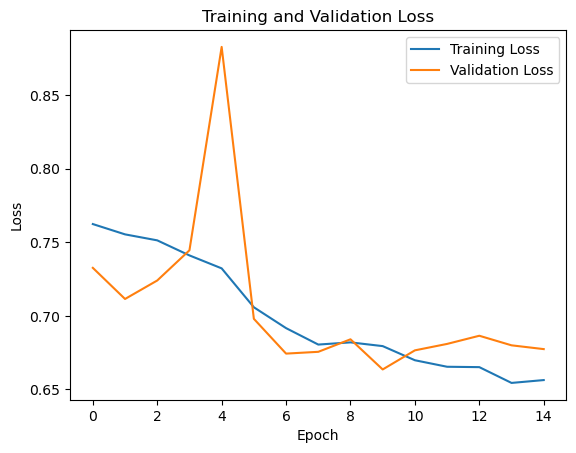

In [4]:
'''
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
'''

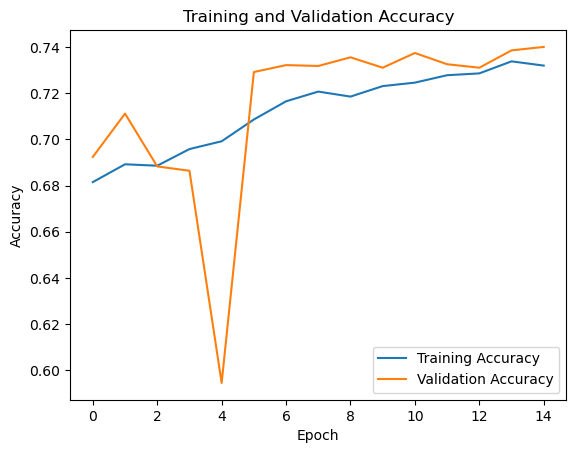

In [5]:
'''
import matplotlib.pyplot as plt

# 绘制训练和验证准确率
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
'''

In [1]:
#model.save(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.740(image_v3.3,efficientnetb6).h5')

NameError: name 'model' is not defined

In [ ]:
#截止前的最後掙扎

In [1]:
'''
from tensorflow.keras.models import load_model
# 載入模型
model = load_model(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.740(image_v3.3,efficientnetb6).h5')
# 顯示模型架構
model.summary()
'''

SyntaxError: EOF while scanning triple-quoted string literal (2032315224.py, line 6)

In [2]:
'''
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Softmax, Dense, Add, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 实例化 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像像素值进行归一化
    rotation_range=20,  # 旋转范围
    width_shift_range=0.2,  # 水平平移范围
    height_shift_range=0.2,  # 垂直平移范围
    horizontal_flip=True,  # 水平翻转
    vertical_flip=True,  # 垂直翻转
    zoom_range=0.2,  # 缩放范围
    brightness_range=[0.8,1.2]  # 亮度范围
)

# 创建训练集生成器
train_generator = train_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/train',  # 训练集目录
    target_size=(224, 224),  # 图像尺寸
    batch_size=4,
    class_mode='categorical'  # 类别模式
)

# 同理，为验证集创建生成器
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    'D:/tf29/Go_competition/AIcupTutorial-main/Training Dataset/play_style_image_v3.3/val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)
'''

Found 23952 images belonging to 3 classes.
Found 2663 images belonging to 3 classes.


In [3]:
'''
# 创建ModelCheckpoint回调，保存验证准确率最高的模型
checkpoint = ModelCheckpoint(r'D:\tf29\Go_competition\AIcupTutorial-main\models\checkpoint\checkpoint_best_model_playstyle(efficientnetb6).h5', save_best_only=True, monitor='val_accuracy')

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-9),
        checkpoint
    ]
)
'''

Epoch 1/100
5988/5988 [==============================] - 1818s 298ms/step - loss: 0.6632 - accuracy: 0.7305 - val_loss: 0.6747 - val_accuracy: 0.7360 - lr: 8.0000e-06
Epoch 2/100
5988/5988 [==============================] - 1811s 302ms/step - loss: 0.6646 - accuracy: 0.7273 - val_loss: 0.6776 - val_accuracy: 0.7379 - lr: 8.0000e-06
Epoch 3/100
5988/5988 [==============================] - 1833s 306ms/step - loss: 0.6617 - accuracy: 0.7302 - val_loss: 0.6740 - val_accuracy: 0.7356 - lr: 8.0000e-06
Epoch 4/100
5988/5988 [==============================] - 1773s 296ms/step - loss: 0.6631 - accuracy: 0.7291 - val_loss: 0.6754 - val_accuracy: 0.7360 - lr: 8.0000e-06
Epoch 5/100
5988/5988 [==============================] - 1795s 300ms/step - loss: 0.6601 - accuracy: 0.7304 - val_loss: 0.6835 - val_accuracy: 0.7379 - lr: 8.0000e-06
Epoch 6/100
  13/5988 [..............................] - ETA: 30:56 - loss: 0.7187 - accuracy: 0.7115

KeyboardInterrupt: 

In [4]:
#model.save(r'D:\tf29\Go_competition\AIcupTutorial-main\models\playstyle_models/model_playstyle_0.737(image_v3.3,efficientnetb6).h5')